---
# Part III 🔥 Advanced: Deep Q-learning (DQN).
---

In [1]:
# Install dependencies
%%capture

!pip install dm-haiku
!pip install optax
!pip install dm_env
!pip install gym[accept-rom-license]
!pip install dm-acme[envs]
!pip install autorom[accept-rom-license]

In [2]:
# Imports

import collections
import random
from typing import Sequence

import chex
import dm_env
from dm_env import specs
import haiku as hk
import jax
import jax.numpy as jnp
from matplotlib import animation
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import optax
import gym
from acme.wrappers import atari_wrapper, gym_wrapper
from acme import wrappers

rc('animation', html='jshtml')
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [ ]:
#@title Some helper functions copied from 4.1

_ACTIONS = (-1, 0, 1)  # Move paddle left, no-op, move paddle right.

class Catch(dm_env.Environment):
  """A Catch environment built on the dm_env.Environment class.

  The agent must move a paddle to intercept falling balls. Falling balls only
  move downwards on the column they are in.

  The observation is an array with shape (rows, columns) containing binary
  values: 0 if a space is empty; 1 if it contains the paddle and 2 for a ball.

  The actions are discrete, and by default there are three available actions:
  move left, stay, and move right.

  The episode terminates when the ball reaches the bottom of the screen.
  """

  def __init__(self,
               rows: int = 10,
               columns: int = 5,
               discount: float = 1.0):
    """Initializes a new Catch environment.

    Args:
      rows: number of rows.
      columns: number of columns.
      discount: discount factor for calculating reward.
    """
    self._rows = rows
    self._columns = columns
    self._discount = discount
    self._board = np.zeros((rows, columns), dtype=np.float32)
    self._ball_x = None
    self._ball_y = None
    self._paddle_x = None
    self._reset_next_step = True

  def reset(self) -> dm_env.TimeStep:
    """Returns the first `TimeStep` of a new episode."""
    self._reset_next_step = False
    # Ball can drop from any column.
    self._ball_x = np.random.randint(self._columns)
    self._ball_y = 0  # Top of matrix.
    self._paddle_x = self._columns // 2  # Centre.

    return dm_env.restart(self._observation())

  def step(self, action: int) -> dm_env.TimeStep:
    """Updates the environment according to the action."""
    if self._reset_next_step:
      return self.reset()

    # Move the paddle.
    dx = _ACTIONS[action]  # Get action. dx = change in x position.
    # Clip to keep paddle in bounds of the environment matrix.
    self._paddle_x = np.clip(self._paddle_x + dx, 0, self._columns - 1)

    # -----------------------------------#
    # Drop the ball down one row: increase y coordinate of the ball by 1.
    self._ball_y += 1
    # -----------------------------------#

    # Check for termination.
    if self._ball_y == self._rows - 1:  # Ball has fallen below the rows.
      # Reward depends on whether the paddle is on the ball (positions match).
      reward = 1. if self._paddle_x == self._ball_x else -1.
      self._reset_next_step = True
      return dm_env.termination(reward=reward, observation=self._observation())

    return dm_env.transition(reward=0., observation=self._observation(),
                             discount=self._discount)

  def observation_spec(self) -> specs.BoundedArray:
    """Returns the observation spec."""
    return specs.BoundedArray(
        shape=self._board.shape,
        dtype=self._board.dtype,
        name='board',
        minimum=0,
        maximum=2)

  def action_spec(self) -> specs.DiscreteArray:
    """Returns the action spec."""
    return specs.DiscreteArray(
        dtype=int, num_values=len(_ACTIONS), name='action')

  def _observation(self) -> np.ndarray:
    self._board.fill(0.)
    self._board[self._ball_y, self._ball_x] = 2.
    self._board[self._rows - 1, self._paddle_x] = 1.

    return self._board.copy()

# Function to animate the observations
def animate(data, interval=200):
  fig = plt.figure(1)
  img = plt.imshow(data[0])
  plt.axis('off')

  def animate(i):
    img.set_data(data[i])

  anim = animation.FuncAnimation(fig, animate, frames=len(data), interval=interval)
  plt.close(1)
  return anim

Transition = collections.namedtuple(
    'Transition', 'obs_tm1 a_tm1 r_t discount_t obs_t')

class TransitionAccumulator:
  """Simple Python accumulator for transitions."""

  def __init__(self):
    self._prev = None
    self._action = None
    self._latest = None

  def push(self, env_output, action):
    self._prev = self._latest
    self._action = action
    self._latest = env_output

  def sample(self):
    return Transition(self._prev.observation, self._action, self._latest.reward,
                      self._latest.discount, self._latest.observation)

  def is_ready(self):
    """Checks if there is previous data stored."""
    return self._prev is not None



So far, we considered look-up tables for value-based RL and neural network as a policy in policy-gradient method. Now we will look into Q-learning with neural network as a function apploximation because look-up table is only possible in this simple environment where the number of states is quite small. This is not scalable to situations where, say, the goal location changes or the obstacles are in different locations at every episode (consider how big the table should be in this situation). Imagine also playing ATARI from pixels where the observation is a frame and the number of possible frames is exponential in the number of pixels on the screen.

<center><img width="200" src="https://storage.googleapis.com/dm-educational/assets/reinforcement-learning-summer-school/atari.gif"></center>



## Neural net-based Q-learning

What we want is just being able to compute the Q-value when fed with a particular $(s, a)$ pair. So we will have a function to do this instead of keeping a big table. We will use function approximation as a way to generalise Q-values over some representation of a very large state space, and we will train our approximator to output accurate Q-value estimates. In this section, we will explore Q-learning with function approximation, which, although theoretically proven to diverge for some degenerate MDPs, can yield impressive results in very large environments. [Playing Atari with Deep Reinforcement Learning](https://deepmind.com/research/publications/playing-atari-deep-reinforcement-learning)  introduced the first deep learning model to successfully learn control policies directly from high-dimensional pixel inputs using RL, and we're going to implement a simplified version of that agent here!

So, we will predict $Q(s, a)$ using a neural network $f()$, which given a vector $s$, will output a vector of Q-values for all possible actions $a$. As a loss to optimise, we will use the same loss as in tabular setting: **TD error**. By training our neural network to output values such that the TD error is minimised, we will also satisfy the Bellman Optimality Equation, which is a good sufficient condition to enforce so that we may obtain an optimal policy.
We will write the TD error as a loss (e.g., with an $L2$ loss, but others would work too), compute its gradient (which are now gradients with respect to individual parameters of the neural network) and slowly improve our Q-value approximation:

$$Loss = \mathbb{E}\left[ \left(r + \gamma \max_{a'} Q(s', a') − Q(s, a)  \right)^2\right].$$

### ⭐ Exercise

1) Fill in the gap to define the network function, similar to how it was done in the previous section 4.2. For our function approximator, we're going to use an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) that takes the observation and outputs Q values for each of the actions. We construct the MLP inside the `__init__` function. We are going to use [Jax](https://github.com/google/jax) and [Haiku](https://github.com/deepmind/dm-haiku) to implement and train our neural nets.

2) Now we have an agent that uses an MLP to compute Q-values. But in its current state, the MLP params are just initialised randomly and not changed at all. We need to add a TD-Learning algorithm to our agent. `learner_step` will receive a collection of data that is collected from interacting with the environment using the `actor_step` function and then update the network parameters by computing the gradient of the loss function with respect to the network parameters. Complete the learner_step function to compute the gradient of the loss with respect to the neural network parameters and make a step. Again, this is very similar to the section 4.3, use that implementation as reference.

In [5]:
class QlearningAgent(object):
  """Q-learning agent."""

  def __init__(self,
               action_spec: specs.DiscreteArray,
               observation_spec: specs.DiscreteArray,
               num_hiddens: Sequence[int] = [50],
               epsilon: float = 0.01,
               learning_rate: float = 0.005):
    self._observation_spec = observation_spec
    self._num_actions = action_spec.num_values
    self._epsilon = epsilon
    self._optimizer = optax.adam(learning_rate)

    def network(obs):
      """Q network of the agent."""
      obs = jnp.expand_dims(obs, 0)
      # -----------------------------------#
      mlp = hk.Sequential(
          [hk.Flatten(),
           hk.nets.MLP(num_hiddens + [self._num_actions])])
      return mlp(obs)
      # -----------------------------------#

    self._network = hk.without_apply_rng(hk.transform(network, apply_rng=True))
    # Jitting for speed.
    self.actor_step = jax.jit(self.actor_step)
    self.learner_step = jax.jit(self.learner_step)

  def initial_params(self, rng_key):
    """Initialises the agent params given the RNG key."""
    sample_input = self._observation_spec.generate_value()
    sample_input = jnp.expand_dims(sample_input, 0)
    return self._network.init(rng_key, sample_input)

  def initial_learner_state(self, params):
    return self._optimizer.init(params)

  def actor_step(self, params, timestep, rng_key, evaluation):
    """Given the observation, computes the action using epsilon-greedy algorithm."""
    qvalues = self._network.apply(params, timestep.observation)
    if np.random.random() > self._epsilon:
      train_a = jnp.argmax(qvalues)
    else:
      train_a = jax.random.choice(rng_key, self._num_actions)

    # If evaluating, return the greedy action. Otherwise, return the
    # epsilon-greedy action.
    return jax.lax.select(evaluation, jnp.argmax(qvalues), train_a)

  def learner_step(self, params: hk.Params, data, learner_state, rng_key):
    """Computes loss, its gradient w.r.t. params, and runs an optimisation step."""
    # -----------------------------------#
    # get the gradient of the loss and the loss of function _loss with respect to params on data
    dloss_dtheta, loss = jax.grad(self._loss, has_aux=True)(params, *data)
    # get the updates and learner_step from _optimizer
    updates, learner_state = self._optimizer.update(
        dloss_dtheta, learner_state)
    # use optax to modify the params with updates and get a new set of params
    params = optax.apply_updates(params, updates)
    # -----------------------------------#
    return params, learner_state, loss

  def _loss(self, params, obs_tm1, a_tm1, r_t, discount_t, obs_t):
    """Computes the TD error loss."""
    q_tm1 = self._network.apply(params, obs_tm1)[0,:] # use [0,:] to cut batch dimension
    q_t = self._network.apply(params, obs_t)[0,:]

    chex.assert_rank([q_tm1, a_tm1, r_t, discount_t, q_t], [1, 0, 0, 0, 1])
    chex.assert_type([q_tm1, a_tm1, r_t, discount_t, q_t],
                     [float, int, float, float, float])

    target_tm1 = r_t + discount_t * jnp.max(q_t)
    target_tm1 = jax.lax.stop_gradient(target_tm1)
    td_error = target_tm1 - q_tm1[a_tm1]
    loss = 0.5 * td_error ** 2
    return loss, loss


## Run Loop
Now we are ready to write the training loop. We're going to use the same transition accumulator from the tabular Q-learning. Before starting the training, we need to initialise the agent's and optimiser's parameters.


In [6]:
train_episodes = 1_001
evaluate_every = 50
eval_episodes = 10
seed = 1221

rng = hk.PRNGSequence(jax.random.PRNGKey(seed))

# # Initialise the environment.
env = Catch()

timestep = env.reset()

# Build and initialise the agent.
agent = QlearningAgent(env.action_spec(),
                       env.observation_spec(),
                       num_hiddens=[20,20],
                       epsilon=0.2,
                       learning_rate=1e-3)
params = agent.initial_params(next(rng))
learner_state = agent.initial_learner_state(params)

# Initialise the accumulator.
accumulator = TransitionAccumulator()

# Run loop.
avg_returns = []
losses = []

for episode in range(train_episodes):

  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  accumulator.push(timestep, None)

  while not timestep.last():
    # Acting.
    action = agent.actor_step(params, timestep, next(rng), False)
    # Agent-environment interaction.
    timestep = env.step(int(action))
    # Accumulate experience.
    accumulator.push(timestep, action)

    # Learning.
    if accumulator.is_ready():
      params, learner_state, loss = agent.learner_step(
          params, accumulator.sample(), learner_state, next(rng))
      losses.append(np.asarray(loss))

  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(params, timestep, next(rng), True)
        timestep = env.step(int(action))
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}")

Episode    0: Average returns: -1.00
Episode   50: Average returns: -0.60
Episode  100: Average returns: 0.40
Episode  150: Average returns: -0.80
Episode  200: Average returns: -0.80
Episode  250: Average returns: 0.20
Episode  300: Average returns: 0.20
Episode  350: Average returns: 0.00
Episode  400: Average returns: 0.60
Episode  450: Average returns: 0.20
Episode  500: Average returns: 0.20
Episode  550: Average returns: 0.60
Episode  600: Average returns: 0.60
Episode  650: Average returns: 0.60
Episode  700: Average returns: 0.40
Episode  750: Average returns: 1.00
Episode  800: Average returns: 1.00
Episode  850: Average returns: 1.00
Episode  900: Average returns: 1.00
Episode  950: Average returns: 1.00
Episode 1000: Average returns: 0.80


### ⭐ Exercise

- How is the learning progresses? Plot both the loss function and the average return that the agent achieves (consider plotting the moving average with `np.convolve` if needed). How stable is the learning (e.g., does the loss go gradually down)?
- Try replacing the Catch environment with CartPole from Policy gradient section. What happens then?

In [7]:
# To experiment with CartPole, replace env=Catch() with
# -----------------------------------#
# env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
# env = wrappers.SinglePrecisionWrapper(env)
# -----------------------------------#

Text(0, 0.5, 'loss')

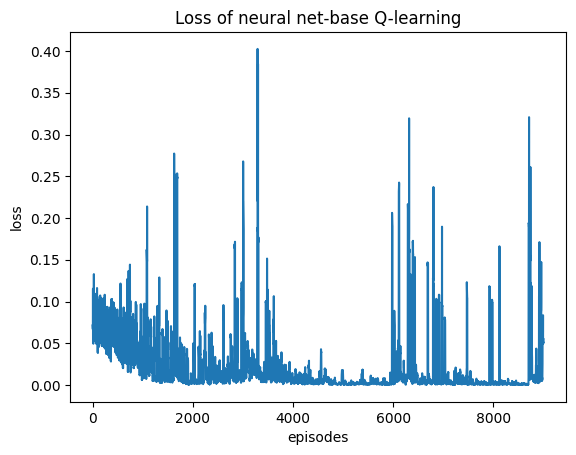

In [8]:
# -----------------------------------#
w=10
plt.plot(np.convolve(losses, np.ones(w), 'valid') / w)
plt.title('Loss of neural net-base Q-learning')
plt.xlabel('episodes')
plt.ylabel('loss')
# -----------------------------------#

Text(0, 0.5, 'return')

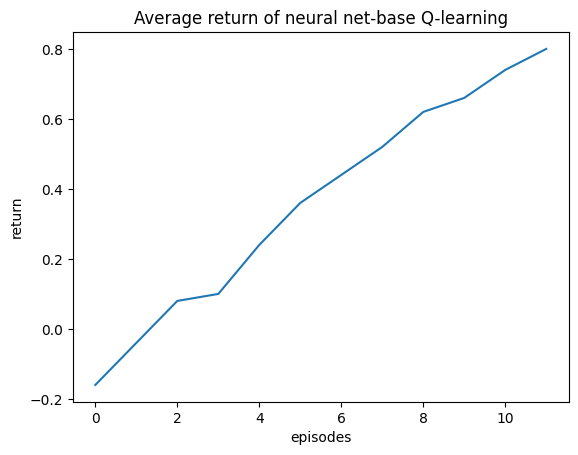

In [9]:
# -----------------------------------#
w=10
plt.plot(np.convolve(avg_returns, np.ones(w), 'valid') / w)
plt.title('Average return of neural net-base Q-learning')
plt.xlabel('episodes')
plt.ylabel('return')
# -----------------------------------#

## DQN Agent

The agent we implemented above, while very successful on some tasks like [TD-Gammon](https://en.wikipedia.org/wiki/TD-Gammon), suffers from divergence issues and is hard to train for more complicated tasks (you might have noticed the issues already in the simple environments that we considered).

The [Deep Q-Learning Agent (DQN)](https://deepmind.com/research/publications/2019/playing-atari-deep-reinforcement-learning) that was first introduced to play Atari games from pixels improves on the Q-learning agent by incorporating two main ideas:

*   `Replay buffer`: To alleviate the problems of correlated data and non-stationary distributions.
*   `Target network`: Use of an iterative update that adjusts the action-values (Q) towards target values that are only periodically updated, thereby reducing correlations with the target".

### Replay buffer

We modify the `TransitionAccumulator` slightly by adding a queue to collect more than one transition. Notice also that `sample` function now takes `batch_size` parameter, similar to what we did in 4.2.

In [10]:
class ReplayBuffer(object):
  """A simple Python replay buffer."""

  def __init__(self, capacity, discount_factor=0.99):
    self._discount_factor = discount_factor
    self._prev = None
    self._action = None
    self._latest = None
    self.buffer = collections.deque(maxlen=capacity)

  def push(self, env_output, action):
    self._prev = self._latest
    self._action = action
    self._latest = env_output

    if action is not None:
      self.buffer.append(
          (self._prev.observation, self._action, self._latest.reward,
           self._latest.discount, self._latest.observation))

  def sample(self, batch_size):
    obs_tm1, a_tm1, r_t, discount_t, obs_t = zip(
        *random.sample(self.buffer, batch_size))
    return (jnp.stack(obs_tm1), jnp.asarray(a_tm1), jnp.asarray(r_t),
            jnp.asarray(discount_t) * self._discount_factor, jnp.stack(obs_t))

  def is_ready(self, batch_size):
    return batch_size <= len(self.buffer)

### Target network

The second ingredient we need is a *target network*.

At each iteration `i`, the target network computes the DQN loss $L_i$ on the parameters $\theta_i$, based on a the set of target parameters $\theta_{i-1}$ and a given batch of sampled trajectories `sample`. As described in the manuscript, the loss function is defined as:

$$L_i (\theta_i) = \mathbb{E}_{s,a \sim \rho(\cdot)} \left[ \left( y_i - Q(s,a ;\theta_i) \right)^2\right],$$

where the target $y_i$ is computed using a bootstrap value computed from Q-value network with target parameters:

$$ y_i = \mathbb{E}_{s' \sim S} \left[r + \gamma \max_{a' \in A} Q(s', a' ; \theta^{\text{target}}_i) \; | \; s, a \right]. $$


In [11]:
# Two sets of parameters, for online and for target network
Params = collections.namedtuple("Params", "online target")
# Learner state includes the counter of the learning steps and optimiser state
LearnerState = collections.namedtuple("LearnerState", "count opt_state")

class DQNAgent(object):
  """Q-learning agent."""

  def __init__(self,
               action_spec: specs.DiscreteArray,
               observation_spec: specs.DiscreteArray,
               num_hiddens: Sequence[int] = [50],
               epsilon: float = 0.01,
               learning_rate: float = 0.005,
               target_period = 10):
    self._observation_spec = observation_spec
    self._num_actions = action_spec.num_values
    self._epsilon = epsilon
    self._target_period = target_period
    self._optimizer = optax.adam(learning_rate)

    def network(obs):
      """Q network of the agent."""
      # Unlike the previous version of the agent, here the observation has a
      # leading batch dimension.
      mlp = hk.Sequential(
          [hk.Flatten(),
           hk.nets.MLP(num_hiddens + [self._num_actions])])
      return mlp(obs)

    self._network = hk.without_apply_rng(hk.transform(network, apply_rng=True))
    # Jitting for speed.
    self.actor_step = jax.jit(self.actor_step)
    self.learner_step = jax.jit(self.learner_step)

  def initial_params(self, rng_key):
    """Initialises the agent params given the RNG key."""
    sample_input = self._observation_spec.generate_value()
    sample_input = jnp.expand_dims(sample_input, 0)
    online_params = self._network.init(rng_key, sample_input)
    return Params(online_params, online_params)

  def initial_learner_state(self, params):
    learner_count = jnp.zeros((), dtype=jnp.float32)
    opt_state = self._optimizer.init(params.online)
    return LearnerState(learner_count, opt_state)

  def actor_step(self, params, timestep, rng_key, evaluation):
    """Given the observation, computes the action using epsilon-greedy algorithm."""
    # The actor step works with batch size 1 but our network expects
    # the inputs to have a batch dimension.
    obs = jnp.expand_dims(timestep.observation, 0)  # Add dummy batch.
    qvalues = self._network.apply(params.online, obs)[0]  # Remove dummy batch.

    if np.random.random() > self._epsilon:
      train_a = jnp.argmax(qvalues)
    else:
      train_a = jax.random.choice(rng_key, self._num_actions)
    # If evaluating, return the greedy action. Otherwise, return the
    # epsilon-greedy action.
    return jax.lax.select(evaluation, jnp.argmax(qvalues), train_a)

  def learner_step(self, params: hk.Params, data, learner_state, rng_key):
    """Computes the loss and its gradient with respect to the parameters and
    does a step of optimisation."""
    # Update the target network parameters periodically.
    is_time = learner_state.count % self._target_period == 0
    target_params = jax.tree_map(
        lambda new, old: jax.lax.select(is_time, new, old),
        params.online, params.target)

    dloss_dtheta, loss = jax.grad(self._loss, has_aux=True)(
        params.online, target_params, *data)

    updates, opt_state = self._optimizer.update(
        dloss_dtheta, learner_state.opt_state)
    online_params = optax.apply_updates(params.online, updates)
    return (
        Params(online_params, target_params),
        LearnerState(learner_state.count + 1, opt_state),
        loss)

  def _loss(self, online_params, target_params, obs_tm1, a_tm1, r_t,
            discount_t, obs_t):
    """Computes the TD error loss."""
    q_tm1 = self._network.apply(online_params, obs_tm1)
    q_t_val = self._network.apply(target_params, obs_t)
    q_t_select = self._network.apply(online_params, obs_t)

    def q_learning_loss(q_tm1, a_tm1,  r_t, discount_t, q_t_value,
                        q_t_selector):
      target_tm1 = r_t + discount_t * q_t_value[q_t_selector.argmax()]
      target_tm1 = jax.lax.stop_gradient(target_tm1)
      return target_tm1 - q_tm1[a_tm1]

    batched_loss = jax.vmap(q_learning_loss)
    td_error = batched_loss(q_tm1, a_tm1, r_t, discount_t, q_t_val, q_t_select)
    loss = jnp.mean(0.5 * td_error ** 2)
    return loss, loss

### Run Loop

The training loop for the DQN agent is identical to the one we used above for the Q-learning agent. We only need to change the accumulator and the agent's class.

In [12]:
batch_size = 10  #@param
discount_factor = 0.99  #@param
replay_buffer_capacity = 100  #@param
train_episodes = 300  #@param
evaluate_every = 25  #@param
eval_episodes = 20  #@param
num_hiddens = [50]  #@param
learning_rate = 0.005 #@param
epsilon = 0.01 #@param
seed = 1221  #@param

rng = hk.PRNGSequence(jax.random.PRNGKey(seed))

# Initialise the environment.
env = Catch()
timestep = env.reset()

# Build and initialise the agent.
agent = DQNAgent(env.action_spec(),
                 env.observation_spec(),
                 num_hiddens=num_hiddens,
                 epsilon=epsilon,
                 learning_rate=learning_rate)
params = agent.initial_params(next(rng))
learner_state = agent.initial_learner_state(params)

# Initialise the accumulator.
accumulator = ReplayBuffer(replay_buffer_capacity, discount_factor)

# Run loop
avg_returns = []
losses = []

for episode in range(train_episodes):
  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  accumulator.push(timestep, None)
  timesteps = []

  while not timestep.last():
    timesteps.append(timestep)
    # Acting.
    action = agent.actor_step(params, timestep, next(rng), False)
    # Agent-environment interaction.
    timestep = env.step(action)
    # Accumulate experience.
    accumulator.push(timestep, action)
    # Learning.
    if accumulator.is_ready(batch_size):
      params, learner_state, loss = agent.learner_step(
          params, accumulator.sample(batch_size), learner_state, next(rng))
      losses.append(np.asarray(loss))

  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(params, timestep, next(rng), True)
        timestep = env.step(action)
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}.")


Episode    0: Average returns: -1.00.
Episode   25: Average returns: 0.00.
Episode   50: Average returns: 0.10.
Episode   75: Average returns: 1.00.
Episode  100: Average returns: 0.40.
Episode  125: Average returns: 0.80.
Episode  150: Average returns: 0.00.
Episode  175: Average returns: 1.00.
Episode  200: Average returns: 1.00.
Episode  225: Average returns: 1.00.
Episode  250: Average returns: 1.00.
Episode  275: Average returns: 1.00.


In [13]:
# Show the last epsiode
animate([item.observation for item in timesteps])

#### ⭐ Exercise

Plot the loss and average return again. How does it look now? How fast is the learning? Experiemnt with:
- batch_size
- size of the network: num_hidden
- number of episodes: num_train
- size of the replay buffer: replay_buffer_capacity
- size of the learning step: learning_rate
- amount of exploration: epsilon
- any other hyperparameters

What effect do they have on learning? Why? Does is learn faster, slower, more or less stable?

Next, experiment with the size of the board in the game.

Text(0, 0.5, 'loss')

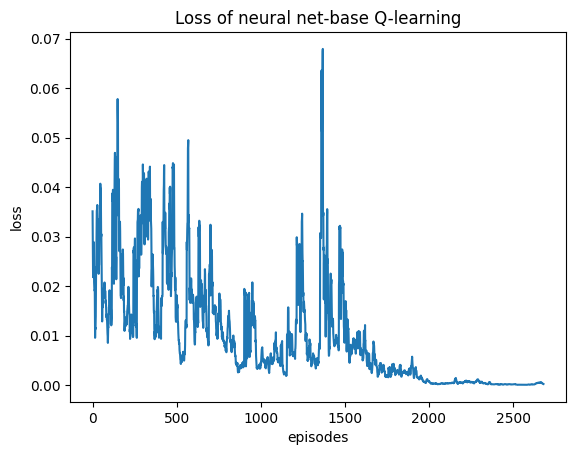

In [14]:
# -----------------------------------#
w=10
plt.plot(np.convolve(losses, np.ones(w), 'valid') / w)
plt.title('Loss of neural net-base Q-learning')
plt.xlabel('episodes')
plt.ylabel('loss')
# -----------------------------------#

Text(0, 0.5, 'return')

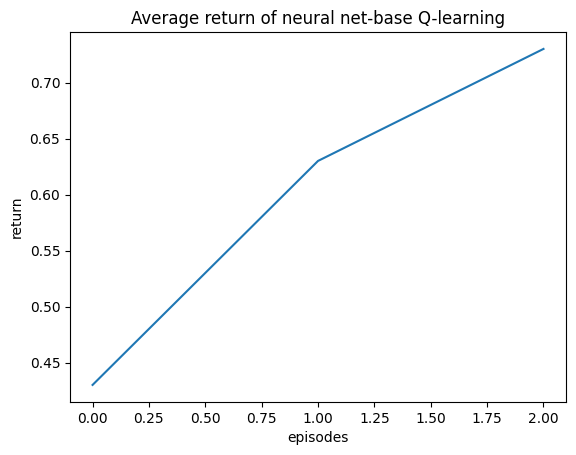

In [15]:
# -----------------------------------#
w=10
plt.plot(np.convolve(avg_returns, np.ones(w), 'valid') / w)
plt.title('Average return of neural net-base Q-learning')
plt.xlabel('episodes')
plt.ylabel('return')
# -----------------------------------#

#### ⭐ Exercise

Now, make DQN agent work with Cartpole environment. Experiment with the paramters again.

In [19]:
# -----------------------------------#
# batch_size = 10  #@param
batch_size = 32  #@param
discount_factor = 0.99  #@param
# replay_buffer_capacity = 100  #@param
replay_buffer_capacity = 301  #@param
train_episodes = 201  #@param
evaluate_every = 50  #@param
eval_episodes = 10  #@param
seed = 1221  #@param
learning_rate = 1e-2 #@param

rng = hk.PRNGSequence(jax.random.PRNGKey(seed))

# Initialise the environment.
# env = Catch()

env = gym_wrapper.GymWrapper(gym.make('CartPole-v1'))
env = wrappers.SinglePrecisionWrapper(env)

timestep = env.reset()

# Build and initialise the agent.
agent = DQNAgent(env.action_spec(),
                 env.observation_spec(),
                 num_hiddens=[20],
                 epsilon=0.4,
                 learning_rate=learning_rate,
                 target_period=100)
params = agent.initial_params(next(rng))
learner_state = agent.initial_learner_state(params)

# Initialise the accumulator.
accumulator = ReplayBuffer(replay_buffer_capacity, discount_factor)

# Run loop
avg_returns = []
losses = []

for episode in range(train_episodes):
  # Prepare agent, environment and accumulator for a new episode.
  timestep = env.reset()
  accumulator.push(timestep, None)
  frames = []

  while not timestep.last():
    frames.append(env.render(mode='rgb_array'))
    # Acting.
    action = agent.actor_step(params, timestep, next(rng), False)
    # Agent-environment interaction.
    timestep = env.step(int(action))
    # Accumulate experience.
    accumulator.push(timestep, action)
    # Learning.
  if accumulator.is_ready(batch_size):
    # Make 10 learning steps after each episode
    for _ in range(10):
      params, learner_state, loss = agent.learner_step(
          params, accumulator.sample(batch_size), learner_state, next(rng))
      losses.append(np.asarray(loss))

  # Evaluation.
  if not episode % evaluate_every:
    returns = []
    for _ in range(eval_episodes):
      timestep = env.reset()
      timesteps = [timestep]
      while not timestep.last():
        action = agent.actor_step(params, timestep, next(rng), True)
        # timestep = env.step(int(action))
        timestep = env.step(int(action))
        timesteps.append(timestep)
      returns.append(np.sum([item.reward for item in timesteps[1:]]))

    avg_returns.append(np.mean(returns))
    print(f"Episode {episode:4d}: Average returns: {avg_returns[-1]:.2f}.")
# -----------------------------------#

Episode    0: Average returns: 9.50.
Episode   50: Average returns: 36.80.
Episode  100: Average returns: 89.10.
Episode  150: Average returns: 123.40.
Episode  200: Average returns: 402.60.


In [20]:
# -----------------------------------#
animate(frames, interval=50)
# -----------------------------------#

Text(0, 0.5, 'return')

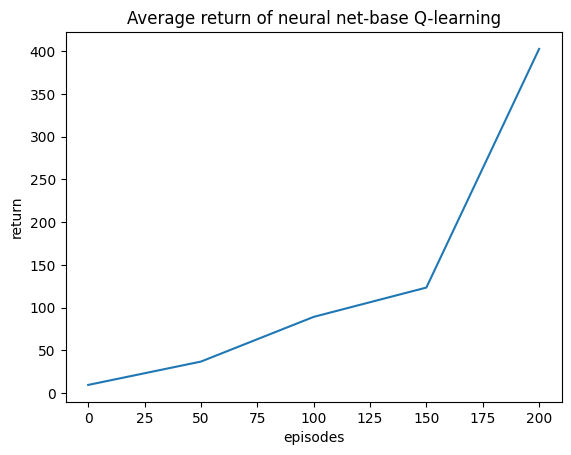

In [24]:
# -----------------------------------#
w=1
plt.plot(np.arange(len(avg_returns))*evaluate_every, avg_returns)
plt.title('Average return of neural net-base Q-learning')
plt.xlabel('episodes')
plt.ylabel('return')
# -----------------------------------#

#### ⭐ Bonus exercise

DQN method on Atari works on the observations which are represented as images. You can try this by either using the image representation from Catch, or by using one of the Atari environment for training (Pong is the simplest, but you can also try Breakout). Note tha training on Atari games would be significantly longer. Good luck!

# Conclusions

🥳 Congratulations on completing the Reinforcement Learning tutorial!

If you would like to learn more about Reinforcement Learning, consider checking:

- [DeepMind x UCL RL Lecture Series](https://www.youtube.com/watch?v=TCCjZe0y4Qc)
- [Introduction to Reinforcement Learning with David Silver](https://www.deepmind.com/learning-resources/introduction-to-reinforcement-learning-with-david-silver)